# <img src="./resources/GA.png" width="25" height="25" /> <span style="color:Blue">Arizona/ Utah MTB Trail Recommender Engine</span> 
---
## <span style="color:Green">EDA</span>      

#### Ryan McDonald -General Assembly 



---

### Notebook Contents:

- [Reading the User Data](#intro)    
- [Trail Difficulty Distribution](#trail)
- [KMeans Preprocessing](#kmeans)
    - [Coordinate Plot](#plot)
    - [Clusters Plot ](#cluster)

**Imports**

In [2]:
# general processing, CSV manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

matplotlib.style.use('ggplot')


<a id='intro'></a>
## 1. Read Data- Arizona and Utah Trail Data

In [3]:
ut_trails = pd.read_csv('./data/trail_dashboard/ut_trails.csv')
ut_trails.head()

,trail_name,length,difficulty,city,popularity,rating,local_club,tot_climb,tot_descent,ave_grade,max_grade,max_elevation,min_elevation,dog_policy,e_bike_policy
0,thunder mountain trail #33098,8.1,INTERMEDIATE/DIFFICULT,"Panguitch, UT",1.000000,4.7,Trail Alliance of Southern Utah (TASU),689,1681,6,27,8263,7084,Off-leash,Unknown
1,wasatch crest,12.5,INTERMEDIATE/DIFFICULT,"Alta, UT",0.998922,4.8,NaN,1084,2656,6,26,9882,7616,No Dogs,Not Allowed
2,captain ahab,4.2,DIFFICULT,"Moab, UT",0.997845,4.7,NaN,326,981,6,23,4898,4034,Leashed,Not Allowed
3,wire mesa loop,7.4,INTERMEDIATE/DIFFICULT,"Springdale, UT",0.996767,4.6,NaN,428,415,2,12,4502,4326,Unknown,Allowed
4,ramblin',3.3,INTERMEDIATE/DIFFICULT,"Moab, UT",0.995690,4.7,NaN,195,398,3,12,5279,4971,Leashed,Not Allowed


In [4]:
az_trails = pd.read_csv('./data/trail_dashboard/az_trails.csv')
az_trails.head()

,trail_name,length,difficulty,city,popularity,rating,local_club,tot_climb,tot_descent,ave_grade,max_grade,max_elevation,min_elevation,dog_policy,e_bike_policy
0,hiline trail,3.1,VERY DIFFICULT,Village of Oak Creek (Big Park),1.000000,4.7,Verde Valley Cyclists Coalition,326.0,695.0,6.0,35.0,4646.0,4086.0,Unknown,Unknown
1,slim shady trail,2.6,INTERMEDIATE/DIFFICULT,Village of Oak Creek (Big Park),0.998953,4.4,Verde Valley Cyclists Coalition,265.0,264.0,4.0,11.0,4464.0,4202.0,Unknown,Unknown
2,mescal,2.4,INTERMEDIATE/DIFFICULT,West Sedona,0.997906,4.6,Verde Valley Cyclists Coalition,206.0,166.0,3.0,11.0,4710.0,4520.0,Unknown,Unknown
3,chuckwagon,5.4,INTERMEDIATE,West Sedona,0.996859,4.5,Verde Valley Cyclists Coalition,559.0,489.0,4.0,13.0,4679.0,4499.0,Unknown,Unknown
4,tortolita preserve loop,9.7,INTERMEDIATE,Tortolita,0.995812,4.2,Sonoran Desert Mountain Bicyclists,520.0,520.0,2.0,4.0,2804.0,2326.0,Unknown,Unknown


In [5]:
az_trails.dtypes

trail_name        object
length           float64
difficulty        object
city              object
popularity       float64
rating           float64
local_club        object
tot_climb        float64
tot_descent      float64
ave_grade        float64
max_grade        float64
max_elevation    float64
min_elevation    float64
dog_policy        object
e_bike_policy     object
dtype: object

<a id='trail'></a>
### Plotting trail difficulty distributions for both states

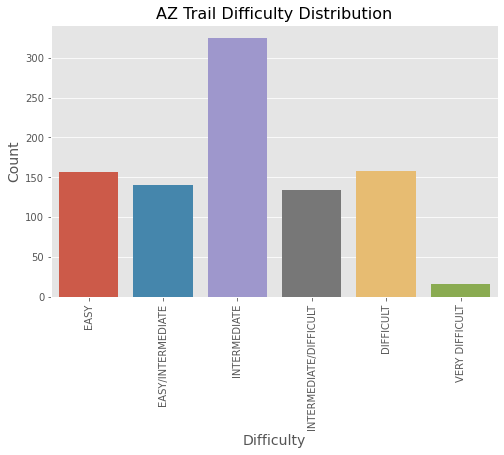

In [6]:
plt.figure(figsize = (8, 5))
sns.countplot(x='difficulty', data= az_trails,
              order=['EASY', 'EASY/INTERMEDIATE', 'INTERMEDIATE', 
                     'INTERMEDIATE/DIFFICULT', 'DIFFICULT', 
                     'VERY DIFFICULT'] )
plt.title('AZ Trail Difficulty Distribution', size = 16)
plt.ylabel('Count', size = 14)
plt.xlabel('Difficulty', size = 14)
plt.xticks(rotation = 90)

plt.show()

Arizona is a majority intermediate riding state.  The state offers many easier trails as well that can help a rider build valuable skills before attemting more challenging trails.

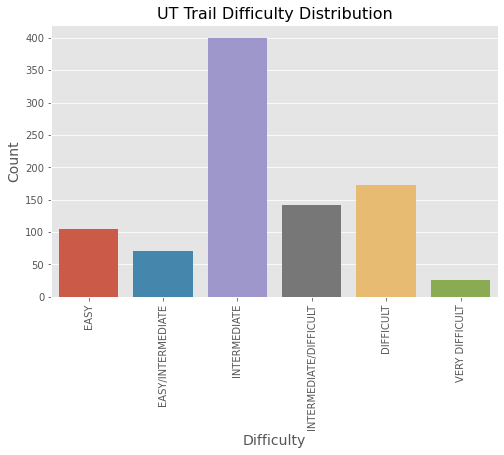

In [7]:
plt.figure(figsize = (8, 5))
sns.countplot(x='difficulty', data= ut_trails, 
              order=['EASY', 'EASY/INTERMEDIATE', 'INTERMEDIATE', 
                     'INTERMEDIATE/DIFFICULT', 'DIFFICULT', 
                     'VERY DIFFICULT'] )
plt.title('UT Trail Difficulty Distribution', size = 16)
plt.ylabel('Count', size = 14)
plt.xlabel('Difficulty', size = 14)
plt.xticks(rotation = 90)

plt.show()

The majority of trails in Utah are also rated intermediate. Overall, Utah caters to more expereienced riders.

<a id='kmeans'></a>
### K-Means Clustering

With our available coordinates, lets see how unsupervised learning clusters our riding areas!  

1. Gathering coordinate data from Arizona and Utah raw data files:

In [9]:
az_coordinates = pd.read_csv('./data/raw_trail_data/arizona_trails.csv', usecols=['longitude', 'latitude'])
ut_coordinates = pd.read_csv('./data/raw_trail_data/utah_trails.csv', usecols=['longitude', 'latitude'])

In [18]:
az_coordinates.head()

,longitude,latitude
0,34.804602,-111.771244
1,34.790166,-111.765576
2,34.906801,-111.824568
3,34.906632,-111.823948
4,32.439082,-111.098523


In [19]:
ut_coordinates.head()

,longitude,latitude
0,37.702572,-112.279340
1,40.613847,-111.570911
2,38.518172,-109.618450
3,37.132839,-113.071259
4,38.637614,-109.784979


In [20]:
# similar sized datasets
az_coordinates.shape, ut_coordinates.shape

((956, 2), (933, 2))

In [16]:
# looking for any missing data.  We'll drop any rows that don't have info
az_coordinates.isnull().sum(), ut_coordinates.isnull().sum()

(longitude    11
 latitude     11
 dtype: int64,
 longitude    4
 latitude     4
 dtype: int64)

In [24]:
# dropping nulls
az_coordinates.dropna(inplace = True)
ut_coordinates.dropna(inplace = True)

# combining the two datasets for K-Means clustering
datasets = [az_coordinates, ut_coordinates]
coordinates = pd.concat(datasets)
coordinates.head()

,longitude,latitude
0,34.804602,-111.771244
1,34.790166,-111.765576
2,34.906801,-111.824568
3,34.906632,-111.823948
4,32.439082,-111.098523


In [25]:
# both datasets are combined now adn ready for processing
coordinates.shape

(1874, 2)

<a id='plot'></a>

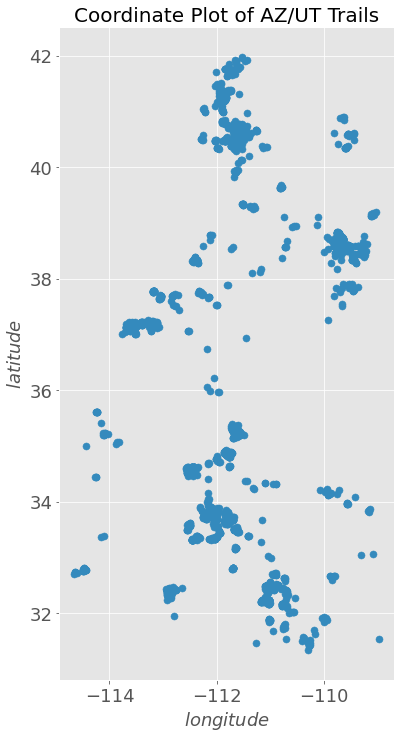

In [36]:
# Plot the scatter
ax = coordinates.plot(kind="scatter", x="latitude", y="longitude", figsize=(6,12), s=50)
plt.xlabel("$longitude$", fontsize=18)
plt.ylabel("$latitude$", fontsize=18)
plt.title('Coordinate Plot of AZ/UT Trails', fontsize= 20)
ax.tick_params(axis='both', which='major', labelsize=18)

#### Cluster Matrix Preprocessing

In [38]:
latlong = coordinates.copy()
ss= StandardScaler()
ss.fit(latlong)
latlong_sc = ss.transform(latlong)

In [39]:
# deciding on number of clusters.
# we will start with k=9
# instantiating KMeans

km=KMeans(n_clusters=9, random_state=42)
km.fit(latlong_sc)

KMeans(n_clusters=9, random_state=42)

In [40]:
# cluster designations
km.labels_

array([1, 1, 1, ..., 0, 0, 2])

In [41]:
# adding cluster row to dataframe
latlong['cluster']=km.labels_
latlong.head()

,longitude,latitude,cluster
0,34.804602,-111.771244,1
1,34.790166,-111.765576,1
2,34.906801,-111.824568,1
3,34.906632,-111.823948,1
4,32.439082,-111.098523,6


#### Visualizing the Clusters and Centroids

In [48]:
#centroids are lcoated at the avg point within each cluster

centroids = pd.DataFrame(
    ss.inverse_transform(km.cluster_centers_),
    columns = ["longitude", "latitude"])
centroids

,longitude,latitude
0,40.672158,-111.674825
1,34.181860,-111.779265
2,38.745893,-109.643079
3,37.442200,-113.119023
4,34.157330,-112.407075
5,33.892934,-114.319550
6,32.243920,-110.893403
7,33.431792,-109.697134
8,32.370842,-112.874450


<a id='cluster'></a>
#### Clustering into 9 distinct riding areas appears to work well with the data.

This could be used inthe future to allow users to select trails from individuals riding cluster areas (in addition to radius search functionality that will be added shortly)

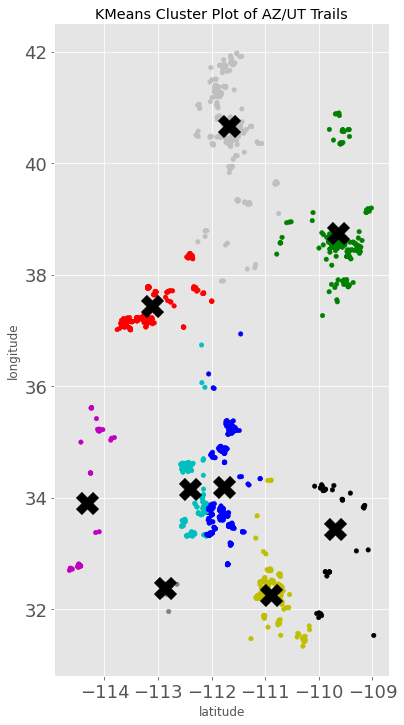

In [82]:
# plotting the clusters with centroids added
## Plot scatter by cluster / color, and centroids

colors = ["0.75", "b", "g","r", "c", "m","y", "k", "0.50"];
latlong['color'] = latlong['cluster'].map(lambda p: colors[p]);


ax = latlong.plot(    
    kind="scatter", 
    x="latitude", y="longitude",
    fontsize=18,
    figsize=(6,12),
    c = latlong['color'],
    xlabel="longitude",
    ylabel="latitude",
    title='KMeans Cluster Plot of AZ/UT Trails'
);

centroids.plot(
    kind="scatter", 
    x="latitude", y="longitude",
    fontsize=18,
    marker="X", c='k', s=500,
    xlabel="longitude",
    ylabel="latitude",
    ax=ax
);
